In [11]:
import tools
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, butter

F0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor



In [12]:
def _bipolar_reference(data_arg):
    (n_time_samples, n_channels) = data_arg.shape
    # separate contact names
    leads = []
    contacts = []
    for i in data_arg.columns:
        if i in ['C3', 'C4', 'ECG1', 'ECG2']:
            n_channels = n_channels - 1
            continue

        M = re.match(r"(\D+)(\d+)", i)
        if M is None:
            n_channels = n_channels - 1
            continue
        leads.append(M.group(1).replace("EEG", "").strip())
        contacts.append(int(M.group(2)))

    leads_contacts = [f"{i}{j:02d}" for i, j in zip(leads, contacts)]
    col_names = []
    data_entries = []
    # find montage channel before
    for index in range(n_channels - 1):
        lead = leads[index]
        contact = contacts[index]

        next_lead_contact = f"{lead}{(contact + 1):02d}"

        try:
            next_index = leads_contacts.index(next_lead_contact)
        except ValueError:
            continue

        col_names.append(f"{leads_contacts[index]}-{leads_contacts[next_index]}")
        data_entries.append(data_arg.iloc[:, index] - data_arg.iloc[:, next_index])
    
    data_entries = np.array(data_entries).T
    bipolar_data = pd.DataFrame(data_entries, columns=col_names, index=data_arg.index)

    return bipolar_data


In [13]:
# username = 'pattnaik'
# pwd_bin_file = '/mnt/local/gdrive/public/USERS/pattnaik/pre-ictal-similarity/code/pat_ieeglogin.bin'

username = 'igvilla'
pwd_bin_file = '/gdrive/public/USERS/igvilla/igv_ieeglogin.bin'

###

# practice of a random new time:
# start_time_sec = 315961
# end_time_sec = 315961 + 60 

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

# practice of a random new time:
# iEEG_filename = 'HUP231_phaseII'
# start_time_usec = start_time_sec * 1e6
# end_time_usec = end_time_sec * 1e6

### 

# LB3_001_phaseII, seizure 1:
start_time_sec = 412652.665551 - 60 # showing starting 1 minute before the seizure
end_time_sec = 412652.665551 + 133

# LB3_001_phaseII, seizure 1:
iEEG_filename = 'HUP227_phaseII_D02'
start_time_usec = start_time_sec * 1e6
end_time_usec = end_time_sec * 1e6




In [14]:
data, fs = tools.get_iEEG_data(username, pwd_bin_file, iEEG_filename, start_time_usec, end_time_usec, select_electrodes=np.arange(50))



In [15]:
start_time_usec, end_time_usec

(412592665551.0, 412785665551.0)

In [16]:
# extract dims
(n_samples, n_channels) = data.shape

# set time array
t_sec = np.linspace(start_time_sec, end_time_sec, n_samples)

# remove 60Hz noise
b, a = iirnotch(F0, Q, fs)
signal_filt = filtfilt(b, a, data, axis=0)

# bandpass between 1 and 120Hz
bandpass_b, bandpass_a = butter(3, [1, 120], btype='bandpass', fs=fs)
signal_filt = filtfilt(bandpass_b, bandpass_a, signal_filt, axis=0)

# format resulting data into pandas DataFrame
signal_filt = pd.DataFrame(signal_filt, columns=data.columns)
signal_filt.index = pd.to_timedelta(t_sec, unit="S")

signal_ref = _bipolar_reference(signal_filt)

In [17]:
np.size(signal_ref)

7905280

In [18]:
signal_ref

,EKG01-EKG02,LL01-LL02,LL02-LL03,LL03-LL04,LL04-LL05,LL05-LL06,LL06-LL07,LL07-LL08,LL08-LL09,LL09-LL10,...,RI08-RI09,RI09-RI10,RI10-RI11,RI11-RI12,RL01-RL02,RL02-RL03,RL03-RL04,RL04-RL05,RL05-RL06,RL06-RL07
4 days 18:36:32.665551,3.771473,234.220979,-21.414361,-191.130849,12.199714,11.765247,-2.909900,-4.145382,-34.258661,44.235265,...,5.940038,8.906885,-31.251295,-13.082670,231.429513,-211.065299,-2.571699,-1.786880,-42.444399,21.549130
4 days 18:36:32.666527567,3.644432,336.413762,-34.003553,-282.818297,10.055960,7.808195,1.870040,-2.799284,-32.276439,46.376593,...,6.275144,10.220288,-34.518323,-14.071638,364.294907,-339.371373,-4.480493,-2.055536,-39.814259,16.761544
4 days 18:36:32.667504135,2.795184,378.413588,-39.928901,-321.164965,8.119671,4.444216,6.523636,-1.296878,-30.403656,48.455277,...,6.292948,11.590003,-37.699740,-14.921417,432.039432,-402.888533,-6.126458,-2.288824,-37.973861,12.716640
4 days 18:36:32.668480702,0.905014,324.733850,-35.293371,-274.703465,6.113362,2.282711,10.863240,0.431618,-28.676314,50.411874,...,5.724138,13.090197,-40.687672,-15.562383,396.532210,-363.679651,-7.342715,-2.485777,-37.395993,10.017842
4 days 18:36:32.669457270,-1.848172,172.507752,-19.817268,-140.862017,3.419501,1.790172,14.665358,2.325852,-27.033754,52.212950,...,4.382784,14.785140,-43.355942,-16.033075,255.302168,-219.228151,-8.124639,-2.664059,-38.028502,8.920463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4 days 18:39:45.661644730,5.358316,409.061403,-48.583362,-453.802687,17.776238,5.151449,-3.403136,-1.294859,1.176363,1.044894,...,-2.124191,-0.418373,0.102008,1.289383,509.069141,-508.789591,5.972384,1.310876,-8.210328,1.469406
4 days 18:39:45.662621298,4.091337,371.055789,-44.743077,-416.042218,13.239815,4.674705,-3.091021,-1.546479,1.330806,0.804880,...,-2.077507,-0.319534,0.007882,1.186008,465.672225,-465.569785,5.540852,1.238003,-7.810378,1.604295
4 days 18:39:45.663597865,2.842914,326.796011,-38.999497,-367.103369,13.593346,4.026628,-2.621698,-1.516522,1.043586,0.858218,...,-1.862731,-0.254955,0.015395,0.978165,415.752706,-415.712069,4.896326,1.033133,-7.075499,1.494157
4 days 18:39:45.664574433,1.557534,264.650549,-30.106123,-298.250549,20.138773,3.188240,-1.920869,-1.171818,0.321268,1.247524,...,-1.437339,-0.240500,0.160006,0.664529,348.651962,-348.471541,4.001669,0.711681,-6.036468,1.154579


In [19]:
signal_ref.to_hdf(f"../data/eeg_pt-{iEEG_filename}_start-{start_time_sec}_end-{end_time_sec}.h5", key='ieeg')

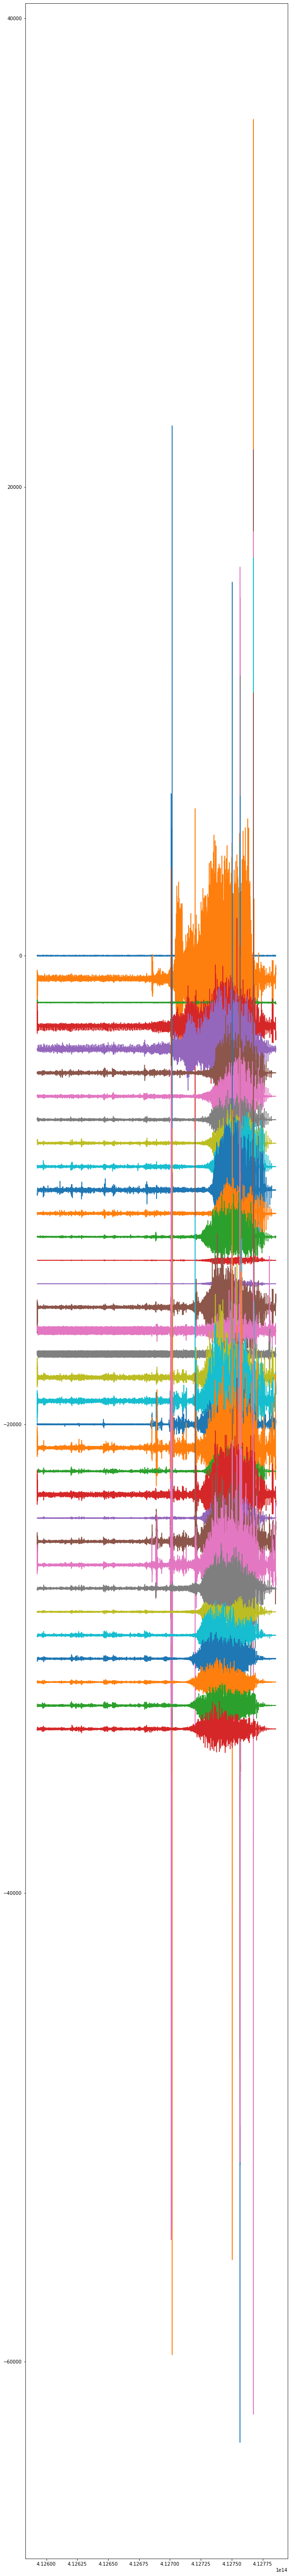

In [20]:
plt.figure(figsize=(10, 100)); plt.plot(signal_ref.iloc[:, 0:34] + np.arange(34)*-1000)